In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
import pickle

import numpy as np
import plotly.graph_objects as go
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from src.eval import get_accuracy_gaps, get_mae_feas
from src.model import get_model, get_C_GL, fix_c_gl, decode_fixing
from src.net import ObjSurrogate, Fixer
from src.utils import load_from_wandb
from src.dataset import EarlyFixingDataset, WellObjDataset

In [3]:
with open('../ef_objs.pkl', 'rb') as f:
    ef_objs = pickle.load(f)

wells = list(ef_objs.keys())

np.random.seed(42)
test_is = np.random.choice(len(wells), int(0.2 * len(wells)), replace=False)
test_wells = [wells[i] for i in test_is]
ef_objs_test = {w: ef_objs[w] for w in test_wells}

ds = EarlyFixingDataset(ef_objs_test)
len(ds)

10000

# Baseline

In [170]:
from copy import copy

y_dummy = torch.zeros((1,2,5)).double()
y_dummy[:,:,0] = 100.
baseline = lambda bsw, gor, q_gl_max: copy(y_dummy)

tensor([[[100.,   0.,   0.,   0.,   0.],
         [100.,   0.,   0.,   0.,   0.]]], dtype=torch.float64)

In [171]:
acc, gaps = get_accuracy_gaps(baseline, ds)

inf_miss = sum(g < 0 for g in gaps) / len(ds)

pos_gaps = [g for g in gaps if g > 0]
avg_gap = sum(pos_gaps) / len(pos_gaps)

print('Accuracy = ', acc)
print('Infeasible = ', inf_miss)
print('Gap = ', avg_gap)

100%|██████████| 10000/10000 [00:01<00:00, 6270.33it/s]


Accuracy =  0.0
Infeasible =  0.0
Gap =  0.21417312177548128


# Supervised

In [6]:
accs = list()
gapss = list()
model_ids = ['o7arihlb', 'jp24pkwb', 'm95c8k43', 'q103zyc1', 'mlnju8dq']
for mid in model_ids:
    fixer = load_from_wandb(Fixer(layers=[25, 25]), mid, 'gef-fs')
    fixer.eval()

    acc, relative_gaps = get_accuracy_gaps(fixer, ds)
    accs.append(acc)
    gapss.append(relative_gaps)

gaps = list()
for relative_gaps in gapss:
    gaps += relative_gaps
inf_miss = sum(g < 0 for g in gaps) / (5 * len(ds))

pos_gaps = [g for g in gaps if g > 0]
avg_gap = sum(pos_gaps) / len(pos_gaps)

print('Accuracy = ', sum(accs) / 5)
print('Infeasible = ', inf_miss)
print('Gap = ', avg_gap)

100%|██████████| 10000/10000 [00:00<00:00, 20797.79it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10



100%|██████████| 10000/10000 [00:00<00:00, 24245.32it/s]


Accuracy =  0.99778
Infeasible =  0.00106
Gap =  0.00013976579690009162


In [7]:
accs

[0.9981, 0.9981, 0.9979, 0.9971, 0.9977]

# Semi-supervised

## Surrogate

In [4]:
surr_ds = WellObjDataset(ef_objs_test)

maes = list()
accs = list()
model_ids = ['2xz377hr', 'vswo49uu', 'tj3pelgm', 'sj73ephx', 'etpop2ab']
for mid in model_ids:
    surrogate = load_from_wandb(ObjSurrogate(layers=[10, 10, 10]), mid, 'gef-fs')
    surrogate.eval()

    mae, acc = get_mae_feas(surrogate, surr_ds)

    maes.append(mae)
    accs.append(acc)
sum(maes) / len(maes), sum(accs) / len(accs)

  0%|          | 0/250000 [00:00<?, ?it/s]/home/bruno/gef-fs/notebooks/../src/eval.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/tensor_new.cpp:230.)
  z_c = torch.Tensor([z_c,])
100%|██████████| 250000/250000 [00:13<00:00, 17979.30it/s]


(60.049558552683415, 0.7823184000000001)

### Surface Example

In [6]:
well_name = ds.wells[0]

with open('../data/raw/'+well_name+'.pkl', 'rb') as f:
    well = pickle.load(f)

bsw, gor = well['bsw'], well['gor']
print(bsw, gor)

C, GL = get_C_GL(well)

Q_liq = np.zeros((len(C), len(GL)))
for i in range(len(C)):
    c = C[i]
    for j in range(len(GL)):
        gl = GL[j]
        try:
            Q_liq[i,j] = well['curve'][c, gl]
        except KeyError:
            Q_liq[i,j] = -1

GL = [gl // 24 for gl in GL]  # Nm3/day -> Nm3/h

wireframe = go.surface.Contours()
wireframe.x.show = True
wireframe.y.show = True
wireframe.x.width = 1.
wireframe.y.width = 1.
fig = go.Figure(data=[go.Surface(z=Q_liq.T / 24, x=C, y=GL, contours=wireframe)])
fig.update_layout(
    autosize=False, width=500, height=500,
    font_family="Latin Modern Roman",
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(range=[min(C)-2, max(C)+2], tickmode='array', tickvals=C),
        yaxis=dict(range=[min(GL)-2e4//24, max(GL)+1e4//24], tickmode='array', tickvals=GL),
    ),
)
fig.update_traces(showscale=False)
fig.update_scenes(xaxis_title_text='whp [kgf/cm²]',  
                  yaxis_title_text='gl [Nm³/h]',  
                  zaxis_title_text='liquid [m³/h]')
fig.show()

0.6323918039056827 142.82612349869703


In [7]:
well_ef_objs = ef_objs[well_name]

surrogate = load_from_wandb(ObjSurrogate(layers=[10, 10, 10]), '2xz377hr', 'gef-fs')
surrogate.eval()

q_gl_max = 160364.917625857

Z_c = np.eye(5)
Z_gl = np.eye(5)

C, GL = get_C_GL(well)

C_pairs = [(C[i], C[i+1]) for i in range(len(C)-1)]
GL_pairs = [(GL[i], GL[i+1]) for i in range(len(GL)-1)]

Y = np.zeros((5,5))
Y_hat = np.zeros((5,5))
for i in range(5):
    c_pair = C_pairs[i]
    z_c = Z_c[i]
    for j in range(5):
        gl_pair = GL_pairs[j]
        z_gl = Z_gl[j]

        Y[i,j] = well_ef_objs[(*c_pair, *gl_pair, q_gl_max)]

        with torch.no_grad():
            bsw_ = torch.Tensor([bsw,])
            gor_ = torch.Tensor([gor,])
            z_c_ = torch.Tensor([z_c,])
            z_gl_ = torch.Tensor([z_gl,])
            q_gl_max_ = torch.Tensor([q_gl_max,])

            Y_hat[i,j] = surrogate(bsw_, gor_, z_c_, z_gl_, q_gl_max_).item()

In [10]:
wireframe = go.surface.Contours()
wireframe.x.show = True
wireframe.y.show = True
wireframe.x.width = 1.
wireframe.y.width = 1.
# fig = go.Figure(data=[go.Surface(z=Y_hat.T, x=C_pairs_, y=GL_pairs_, contours=wireframe)])
x = np.arange(5)
y = np.arange(5)
color1 = 'rgba(255,0,0,0.5)'
color2 = 'rgba(0,0,255,0.5)'
# color1 = 'rgba(220,20,60,0.5)'
# color2 = 'rgba(100,149,237,0.5)'
fig = go.Figure(data=[
    go.Surface(name='P',showlegend=True, z=Y.T, x=x, y=y, colorscale=[[0, color1], [1,color1]], contours=wireframe),
    go.Surface(name='S', showlegend=True,z=Y_hat.T, x=x, y=y, colorscale=[[0, color2], [1,color2]], contours=wireframe)
])
fig.update_layout(
    autosize=False, width=500, height=500,
    font_family="Latin Modern Roman",
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        # aspectmode  ='cube',
        # aspectratio = dict(x=1, y=1, z=1),
        # xaxis = dict(range=[0, 5], ticks='outside', tickwidth=5, tickcolor='yellow',
        #             tickvals=tick_values, ticktext=tick_values),
        xaxis = dict(range=[-0.2, 4.2], tickvals=x, ticktext=[f"{int(c1)}-{int(c2)}" for c1,c2 in C_pairs]),
        yaxis = dict(range=[-0.3, 4.2], tickvals=y, ticks='outside', ticktext=[f"{gl1//24e3:.1f}k-{gl2//24e3:.1f}k" for gl1,gl2 in GL_pairs]),
        # zaxis = dict(range=[-1, 1], nticks=5),
    ),
    # showlegend=True,
)
fig.update_traces(showscale=False)
fig.update_scenes(xaxis_title_text='whp [kgf/cm²]',  
                  yaxis_title_text='gl [Nm³/h]',  
                  zaxis_title_text='liquid [m³/h]')
fig.show()

## Fixer

In [163]:
accs = list()
gapss = list()
model_ids = ['jtf1baqr', '8x2wtn2c', 'r3gkwm67', 'zni5mpm3', 'xr36e99h']
for mid in model_ids:
    fixer = load_from_wandb(Fixer(layers=[25, 25]), mid, 'gef-fs')
    fixer.eval()

    acc, relative_gaps = get_accuracy_gaps(fixer, ds)
    accs.append(acc)
    gapss.append(relative_gaps)

gaps = list()
for relative_gaps in gapss:
    gaps += relative_gaps
inf_miss = sum(g < 0 for g in gaps) / (5 * len(ds))

pos_gaps = [g for g in gaps if g > 0]
avg_gap = sum(pos_gaps) / len(pos_gaps)

print('Accuracy = ', sum(accs) / 5)
print('Infeasible = ', inf_miss)
print('Gap = ', avg_gap)

100%|██████████| 10000/10000 [00:01<00:00, 5857.05it/s]


Accuracy =  0.3231
Infeasible =  0.04192
Gap =  0.03638329197768204


(array([8620., 5930., 5148., 4976., 3910., 1785.,  794.,  375.,  156.,
          55.]),
 array([7.74121057e-05, 6.72200275e+00, 1.34439281e+01, 2.01658534e+01,
        2.68877788e+01, 3.36097041e+01, 4.03316295e+01, 4.70535548e+01,
        5.37754801e+01, 6.04974055e+01, 6.72193308e+01]),
 <BarContainer object of 10 artists>)

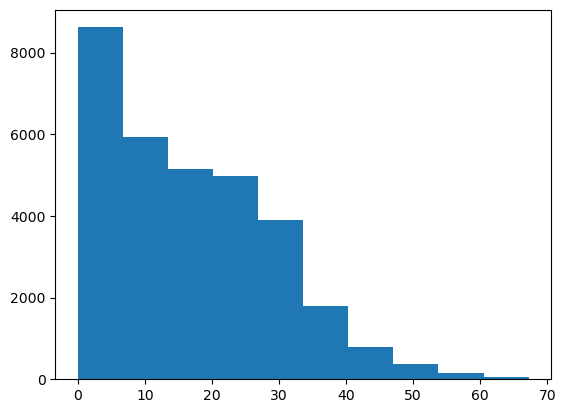

In [144]:
plt.hist(pos_gaps)